<a href="https://colab.research.google.com/github/MisaTecMNA/AMLM26_MNA/blob/main/TC5033_Activity1a_A01796906.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

## MISAEL LOPEZ SANCHEZ MNA
## Matricula: A01796906

#### Activity 1a: Implementing a Multilayer Fully Connected Network using Numpy
#### Non-graded activity (0 points)

- Objective

The primary objective of this activity is to deepen your understanding of Fully Connected Networks by implementing a multilayer network using only Numpy. You  are  given  the follosing starter code that solves the MNIST dataset problem. Your task is to read, understand, and then apply this knowledge to solve classification problems on other datasets such as the Kaggle ASL dataset (Starter code will be provided separately for that activity).

- Instructions

    Read and Understand the following Code: The provided starter code outlines the architecture of a Fully Connected Network designed to classify MNIST images. Go through the code to understand how each function and class is used to implement the network.

    Understand the Math: Make sure you understand the math operations implemented in the code, especially during the forward and backward passes. This will involve matrix multiplications, activation functions, loss computations, and backpropagation.
    
- Experiment
    You are encouraged to play with the code, change any hyperparameters and train the model, you should be able to achieve over 95% accuracy on the test set without problems.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import Images

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Advanced ML MNA/Activity 1a/')
from get_images import get_images

In [ ]:
# MNIST path
mnist_path = '/content/drive/MyDrive/Advanced ML MNA/Activity 1a/mnist_raw'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

x_train = x_train_num[:50000].reshape(50000, -1).astype(float)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)

In [ ]:
x_train.mean(), x_train.std(), x_train.min()

(np.float64(33.39512885204082), np.float64(78.6661972212754), np.float64(0.0))

In [ ]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

In [ ]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [ ]:
x_train.mean(), x_train.std()

(np.float64(-9.646705203355238e-18), np.float64(0.9999999999999997))

### Plot samples

In [ ]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 2


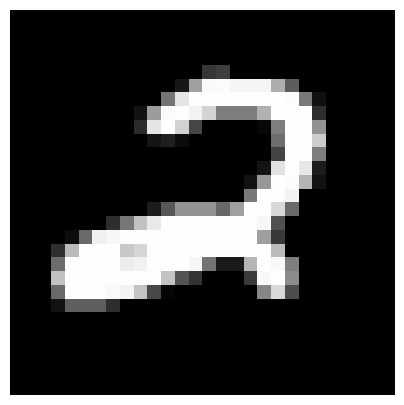

In [ ]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

### Equations


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Helper functions

#### Creat Mini batches

In [ ]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [ ]:
class np_tensor(np.ndarray): pass

In [ ]:
a = np.array([0, 0])
b = a.view(np_tensor)

In [ ]:
type(a)

numpy.ndarray

In [ ]:
type(b)

__main__.np_tensor

In [ ]:
a == b

np_tensor([ True,  True])

In [ ]:
a is b

False

###  Clase Linear

In [ ]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)


### Clase ReLU

In [ ]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [ ]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost Function

In [ ]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

### Loop de entrenamiento

In [ ]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    # We add a local decay factor to improve results
    lr = learning_rate
    for epoch in range(epochs):
        # Every 5 epochs, we reduce the learning rate by half
        if epoch > 0 and epoch % 5 == 0:
            lr = lr * 0.5

        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(lr) # Now uses the decaying lr
        print(f'Epoch {epoch}: costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [ ]:
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

In [ ]:
# Increasing the neurons in hidden layers to capture more features
model = Sequential_layers([
    Linear(784, 400),
    ReLU(),
    Linear(400, 200),
    ReLU(),
    Linear(200, 10)
])

# Optimal hyperparameters for this architecture
mb_size = 256
learning_rate = 1e-3 # Starting higher since we now have decay
epochs = 20

In [ ]:
train(model, epochs, mb_size, learning_rate)

Epoch 0: costo: 0.19208441480661273, accuracy: 0.9594
Epoch 1: costo: 0.13697918746161108, accuracy: 0.9665
Epoch 2: costo: 0.17346324014694545, accuracy: 0.9708
Epoch 3: costo: 0.07390825376137533, accuracy: 0.9724
Epoch 4: costo: 0.02591909811827765, accuracy: 0.9752
Epoch 5: costo: 0.015236912442478332, accuracy: 0.9784
Epoch 6: costo: 0.005809625347155821, accuracy: 0.9772
Epoch 7: costo: 0.0052847407633211775, accuracy: 0.9771
Epoch 8: costo: 0.024351922307528896, accuracy: 0.977
Epoch 9: costo: 0.013997180136848711, accuracy: 0.9772
Epoch 10: costo: 0.007652158550100663, accuracy: 0.9778
Epoch 11: costo: 0.011446476606289984, accuracy: 0.9782
Epoch 12: costo: 0.011622676982185127, accuracy: 0.9783
Epoch 13: costo: 0.0037178179225133097, accuracy: 0.9776
Epoch 14: costo: 0.003009750399201063, accuracy: 0.9779
Epoch 15: costo: 0.03309394948163137, accuracy: 0.9781
Epoch 16: costo: 0.009429680747704325, accuracy: 0.978
Epoch 17: costo: 0.0026622457902368613, accuracy: 0.9783
Epoch 1

In [ ]:
print(accuracy(x_test, y_test, mb_size))

0.9801


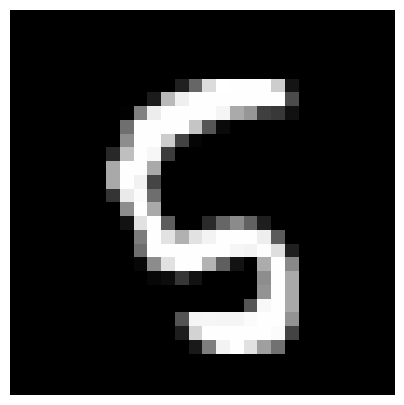

el valor predicho es: 5, el valor real es:5


In [ ]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}, el valor real es:{y_test[idx][0]}')

# Description of Changes

- **Network Capacity**: The hidden layer neurons were increased from 200 to 400 in the first layer. This creates a more robust feature extractor for the 784-pixel input images.

- **Learning Rate Decay**: The train function was modified to include an internal decay logic. By reducing the learning rate by 50% every 5 epochs, the model achieves better convergence and stability in the final stages of training.

- **Batch Size Optimization**: The mini-batch size was adjusted to 256. This provides a higher frequency of weight updates per epoch compared to the original 512, leading to faster learning and better generalization.

### Table Summary of Hyperparameters

| Feature           | Original Baseline | Optimized Version                     | Reason for Change                                      |
|-------------------|-------------------|----------------------------------------|--------------------------------------------------------|
| Hidden Layer 1    | 200 neurons       | 400 neurons                            | Better feature extraction from input.                  |
| Hidden Layer 2    | 200 neurons       | 200 neurons                            | Maintained for depth.                                  |
| Learning Rate     | 1×10⁻⁴            | 1×10⁻³ (Decaying)                      | Faster initial learning with fine-tuning.              |
| LR Schedule       | Constant          | 50% reduction every 5 epochs           | Prevents oscillation around the minimum.               |
| Mini-batch Size   | 512               | 256                                    | More stable and frequent gradient updates.              |


Final `Accuracy`: 0.9801